# The "You Are What You Eat" Customer Segmentation

### Project Overview

#### Context

The Senior Management team from our client, a supermarket chain, are disagreeing about how customers are shopping, and how lifestyle choices may affect which food areas customers are shopping into, or more interestingly, not shopping into.

They have asked us to use data, and Machine Learning to help segment up their customers based upon their engagement with each of the major food categories - aiding business understanding of the customer base, and to enhance the relevancy of targeted messaging & customer communications.

#### Actions

We firstly needed to compile the necessary data from sevaral tables in the database, namely the transactions table and the product_areas table. We joined together the relevant information using Pandas, and then aggregated the transactional data across product areas, from the most recent six month to a customer level. The final data for clustering is, for each customer, the percentage of sales allocated to each product area.

As a starting point, we test & apply k-means clustering for this task. We need to apply some data pre-processing, most importantly feature scaling to ensure all variables exist on the same scale - a very important consideration for distance based algorithms such as k-means.

As k-means is an unsupervised learning approach, in other words there are no labels - we use a process known as Within Cluster Sum of Squares (WCSS) to understand what a “good” number of clusters or segments is.

Based upon this, we apply the k-means algorithm onto the product area data, append the clusters to our customer base, and then profile the resulting customer segments to understand what the differentiating factors were!

### Import Required packages

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt

### Data Overview

We are primarily looking to discover segments of customers based upon their transactions within food based product areas so we will need to only select those.

In the code below, we:

- Import the required python packages & libraries
- Import the tables from the database
- Merge the tables to tag on product_area_name which only exists in the product_areas table
- Drop the non-food categories
- Aggregate the sales data for each product area, at customer level
- Pivot the data to get it into the right format for clustering
- Change the values from raw dollars, into a percentage of spend for each customer (to ensure each customer is comparable)


In [6]:
# import tables from database
transactions = pd.read_excel("data/retail_store_database.xlsx", sheet_name= "transactions")
product_areas = pd.read_excel("data/retail_store_database.xlsx", sheet_name= "product_areas")

# merge product_area_name on
transactions = pd.merge(transactions, product_areas, how = "inner", on = "product_area_id")

# drop the non-food category
transactions.drop(transactions[transactions["product_area_name"] == "Non-Food"].index, inplace = True)

# aggregate sales at customer level (by product area)
transaction_summary = transactions.groupby(["customer_id", "product_area_name"])["sales_cost"].sum().reset_index()

# pivot data to place product areas as columns
transaction_summary_pivot = transactions.pivot_table(index = "customer_id",
                                                    columns = "product_area_name",
                                                    values = "sales_cost",
                                                    aggfunc = "sum",
                                                    fill_value = 0,
                                                    margins = True,
                                                    margins_name = "Total").rename_axis(None,axis = 1)

# transform sales into % sales
transaction_summary_pivot = transaction_summary_pivot.div(transaction_summary_pivot["Total"], axis = 0)

# drop the "total" column as we don't need that for clustering
data_for_clustering = transaction_summary_pivot.drop(["Total"], axis = 1)


After the data pre-processing using Pandas, we have a dataset for clustering that looks like the below sample:

In [8]:
data_for_clustering.head()

,Dairy,Fruit,Meat,Vegetables
customer_id,,,,
1,0.271547,0.203804,0.401244,0.123405
2,0.246200,0.197656,0.394250,0.161894
3,0.142496,0.232527,0.527821,0.097156
4,0.341088,0.244770,0.272134,0.142008
5,0.212754,0.249691,0.430338,0.107218


The data is at customer level, and we have a column for each of the highest level food product areas. Within each of those we have the percentage of sales that each customer allocated to that product area over the past six months.

### K-Means


#### Concept Overview

K-Means is an unsupervised learning algorithm, meaning that it does not look to predict known labels or values, but instead looks to isolate patterns within unlabelled data.

The algorithm works in a way where it partitions data-points into distinct groups (clusters) based upon their similarity to each other.

This similarity is most often the eucliedean (straight-line) distance between data-points in n-dimensional space. Each variable that is included lies on one of the dimensions in space.

The number of distinct groups (clusters) is determined by the value that is set for “k”.

The algorithm does this by iterating over four key steps, namely:

- It selects “k” random points in space (these points are known as centroids)
- It then assigns each of the data points to the nearest centroid (based upon euclidean distance)
- It then repositions the centroids to the mean dimension values of it’s cluster
- It then reassigns each data-point to the nearest centroid
- Steps 3 & 4 continue to iterate until no data-points are reassigned to a closer centroid.

### Data Preprocessing

There are three vital preprocessing steps for k-means, namely:

- Missing values in the data
- The effect of outliers
- Feature Scaling


#### Missing Values

Missing values can cause issues for k-means, as the algorithm won’t know where to plot those data-points along the dimension where the value is not present. If we have observations with missing values, the most common options are to either remove the observations, or to use an imputer to fill-in or to estimate what those value might be.

As we aggregated our data for each customer, we actually don’t suffer from missing values so we don’t need to deal with that here.

#### Outliers

As k-means is a distance based algorithm, outliers can cause problems. The main issue we face is when we come to scale our input variables, a very important step for a distance based algorithm.

We don’t want any variables to be “bunched up” due to a single outlier value, as this will make it hard to compare their values to the other input variables. We should always investigate outliers rigorously - however in our case where we’re dealing with percentages, we thankfully don’t face this issue!

#### Feature Scaling

Again, as k-means is a distance based algorithm, in other words it is reliant on an understanding of how similar or different data points are across different dimensions in n-dimensional space, the application of Feature Scaling is extremely important.

Feature Scaling is where we force the values from different columns to exist on the same scale, in order to enchance the learning capabilities of the model. There are two common approaches for this, Standardisation, and Normalisation.

Standardisation rescales data to have a mean of 0, and a standard deviation of 1 - meaning most datapoints will most often fall between values of around -4 and +4.

Normalisation rescales datapoints so that they exist in a range between 0 and 1.

For k-means clustering, either approach is going to be far better than using no scaling at all. Here, we will look to apply normalisation as this will ensure all variables will end up having the same range, fixed between 0 and 1, and therefore the k-means algorithm can judge each variable in the same context. Standardisation can result in different ranges, variable to variable, and this is not so useful (although this isn’t explcitly true in all scenarios).

Another reason for choosing Normalisation over Standardisation is that our scaled data will all exist between 0 and 1, and these will then be compatible with any categorical variables that we have encoded as 1’s and 0’s (although we don’t have any variables of this type in our task here).

In our specific task here, we are using percentages, so our values are already spread between 0 and 1. We will still apply normalisation for the following reason. One of the product areas might commonly make up a large proportion of customer sales, and this may end up dominating the clustering space. If we normalise all of our variables, even product areas that make up smaller volumes, will be spread proportionately between 0 and 1!

The below code uses the in-built MinMaxScaler functionality from scikit-learn to apply Normalisation to all of our variables. The reason we create a new object (here called data_for_clustering_scaled) is that we want to use the scaled data for clustering, but when profiling the clusters later on, we may want to use the actual percentages as this may make more intuitive business sense, so it’s good to have both options available!

In [12]:
# create our scaler object
scale_norm = MinMaxScaler()

# normalise the data
data_for_clustering_scaled = pd.DataFrame(scale_norm.fit_transform(data_for_clustering), columns = data_for_clustering.columns)

### Finding A Good Value For k

At this point here, our data is ready to be fed into the k-means clustering algorithm. Before that however, we want to understand what number of clusters we want the data split into.

In the world of unsupervised learning, there is no right or wrong value for this - it really depends on the data you are dealing with, as well as the unique scenario you’re utilising the algorithm for. From our client, having a very high number of clusters might not be appropriate as it would be too hard for the business to understand the nuance of each in a way where they can apply the right strategies.

Finding the “right” value for k, can feel more like art than science, but there are some data driven approaches that can help us!

The approach we will utilise here is known as Within Cluster Sum of Squares (WCSS) which measures the sum of the squared euclidean distances that data points lie from their closest centroid. WCSS can help us understand the point where adding more clusters provides little extra benefit in terms of separating our data.

By default, the k-means algorithm within scikit-learn will use k = 8 meaning that it will look to split the data into eight distinct clusters. We want to find a better value that fits our data, and our task!

In the code below we will test multiple values for k, and plot how this WCSS metric changes. As we increase the value for k (in other words, as we increase the number or centroids or clusters) the WCSS value will always decrease. However, these decreases will get smaller and smaller each time we add another centroid and we are looking for a point where this decrease is quite prominent before this point of diminishing returns.

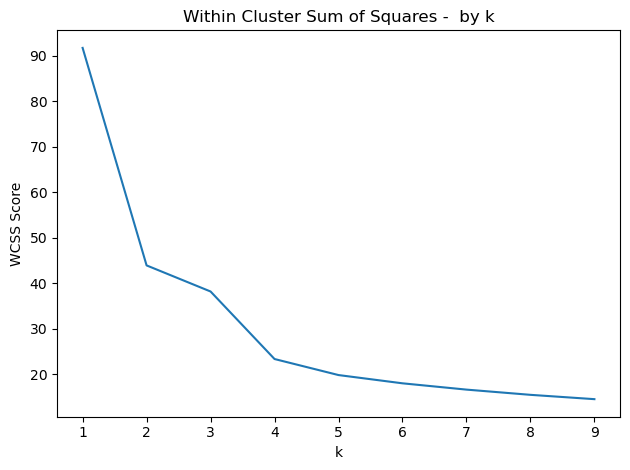

In [14]:
# set up range for search, and empty list to append wcss scores to
k_values = list(range(1,10))
wcss_list = []

# loop through each possible value of k, fit to the data, append the wcss score
for k in k_values:
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(data_for_clustering_scaled)
    wcss_list.append(kmeans.inertia_)

# plot wcss by k
plt.plot(k_values, wcss_list)
plt.title("Within Cluster Sum of Squares -  by k")
plt.xlabel("k")
plt.ylabel("WCSS Score")
plt.tight_layout()
plt.show()

Based upon the shape of the above plot - there does appear to be an elbow at k = 3. Prior to that we see a significant drop in the WCSS score, but following the decreases are much smaller, meaning this could be a point that suggests adding more clusters will provide little extra benefit in terms of separating our data. A small number of clusters can be beneficial when considering how easy it is for the business to focus on, and understand, each - so we will continue on, and fit our k-means clustering solution with k = 3.

### Model Fitting

The below code will instantiate our k-means object using a value for k equal to 3. We then fit this object to our scaled dataset to separate our data into three distinct segments or clusters.

In [17]:
# instantiate our k-means object
kmeans = KMeans(n_clusters = 3, random_state = 42)

# fit to our data
kmeans.fit(data_for_clustering_scaled)

KMeans(n_clusters=3, random_state=42)

#### Append Clusters To Customers

With the k-means algorithm fitted to our data, we can now append those clusters to our original dataset, meaning that each customer will be tagged with the cluster number that they most closely fit into based upon their sales data over each product area.

In the code below we tag this cluster number onto our original dataframe.

In [19]:
# add cluster labels to our original data
data_for_clustering["cluster"] = kmeans.labels_

### Cluster Profiling

Once we have our data separated into distinct clusters, our client needs to understand what is is that is driving the separation. This means the business can understand the customers within each, and the behaviours that make them unique.

#### Cluster Sizes
In the below code we firstly assess the number of customers that fall into each cluster.

In [21]:
# check cluster sizes
data_for_clustering["cluster"].value_counts(normalize=True)

cluster
0    0.413318
1    0.349024
2    0.237658
Name: proportion, dtype: float64

Running that code shows us that the three clusters are different in size, with the following proportions:

- Cluster 0: 41.3% of customers
- Cluster 2: 34.9% of customers
- Cluster 1: 23.7% of customers

Based on these results, it does appear we do have a skew toward Cluster 0 with Cluster 1 & Cluster 2 being proportionally smaller. This isn’t right or wrong, it is simply showing up pockets of the customer base that are exhibiting different behaviours - and this is exactly what we want.

#### Cluster Attributes

To understand what these different behaviours or characteristics are, we can look to analyse the attributes of each cluster, in terms of the variables we fed into the k-means algorithm.

In [24]:
# profile clusters (mean % sales for each product area)
cluster_summary = data_for_clustering.groupby("cluster")[["Dairy","Fruit","Meat","Vegetables"]].mean().mul(100).reset_index()

cluster_summary.rename(
    columns={col: f"{col} (%)" for col in ["Dairy", "Fruit", "Meat", "Vegetables"]},
    inplace=True)

# The code results in the following table
cluster_summary.head()

,cluster,Dairy (%),Fruit (%),Meat (%),Vegetables (%)
0,0,23.821375,20.810100,41.454657,13.913868
1,1,21.266355,33.592844,31.464455,13.676346
2,2,18.184140,52.330242,0.262483,29.223135


For Cluster 0 we see a reasonably significant portion of spend being allocated to each of the product areas. For Cluster 1 we see quite high proportions of spend being allocated to Fruit & Meat, but little on the Dairy & MVegetables product areas. Finally customers in Cluster 2 spend, on average, significant portions within Dairy, Fruit & Vegetables, but very little in the Meat product area - so, we would make an early hypothesis that these customers are more along the lines of those following a vegetarian diet.

### Application

Even those this is a simple solution, based upon high level product areas it will help leaders in the business, and category managers gain a clearer understanding of the customer base.

Tracking these clusters over time would allow the client to more quickly react to dietary trends, and adjust their messaging and inventory accordingly.

Based upon these clusters, the client will be able to target customers more accurately - promoting products & discounts to customers that are truly relevant to them - overall enabling a more customer focused communication strategy.